# Generating Simulated Data for Prevalence Estimation Tasks

We will generate six datasets, all under the `data` folder.

* `dataset1_base`: Extrinsic labels with a good classifier
* `dataset1_target`: Extrinsic labels with a good classifier
* `dataset2_base`: Extrinsic labels with a bad classifier
* `dataset2_target`: Extrinsic labels with a bad classifier
* `dataset3_base`: Extrinsic labels with mixed subgroups (a good classifier and a bad classifier)
* `dataset3_target`: Extrinsic labels with mixed subgroups (a good classifier and a bad classifier)
* `dataset4_base`: Intrinsic labels with a good classifier
* `dataset4_target`: Intrinsic labels with a good classifier
* `dataset5_base`: Intrinsic labels with a bad classifier
* `dataset5_target`: Intrinsic labels with a bad classifier
* `dataset6_base`: Intrinsic labels with mixed subgroups (a good classifier and a bad classifier)
* `dataset6_target`: Intrinsic labels with mixed subgroups (a good classifier and a bad classifier)

### Data Format

|        | has_url | lang | UC(X) | CC(X) | GT |
|--------|---------|------|-------|-------|----|
| item 1 |   yes   |  en  |  0.37 |  0.37 |  0 |
| item 2 |   no    |  en  |  0.21 |  0.37 |  0 |
| item 3 |   no    |  es  |  0.89 |  0.37 |  1 |
|        |         |      |       |       |    |
| item n |   yes   |  es  |  0.24 |  0.37 |  0 |

In [1]:
from collections import defaultdict, Counter
import random
import math
import numpy as np
import pandas as pd
from scipy import stats

from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter
from sklearn.linear_model import LogisticRegression

from util import MixtureModel

In [2]:
positive_color = '#3d85c6'
negative_color = '#cc0000'
unknown_color = '#666666'

num_theor_slice = 100
theor_cx_axis = np.linspace(0, 1, num_theor_slice + 1)
num_empir_bin = 20
empir_cx_axis = np.linspace(0, 1, num_empir_bin + 1)

In [3]:
def get_bin_idx(score, size=10):
    return min(int(score * size), size-1)

## Intrinsic Labels $GT \rightarrow \mathcal{X}$

### If the data generating process is $GT \rightarrow \mathcal{X}$

Data generating process:
- For any GT positive items, their uncalibrated classifier scores $P(UC(X)|GT=1)$ follow a Beta distribution $Beta(\alpha_p, \beta_p)$. If $\alpha_p > \beta_p$, the distribution is left skewed.
- For any GT negative items, their uncalibrated classifier scores $P(UC(X)|GT=0)$ follow a Beta distribution $Beta(\alpha_n, \beta_n)$. If $\alpha_n < \beta_n$, the distribution is right skewed.

Random variable that we allow it to change between base and target period:
- Prevalence of GT positive items, $P(GT=1)$

Statistics that we can derive from the above parameters:
- Joint distribution between $UC(X)$ and $GT$, $JD(UC(X), GT)$
- Observed classifier score distribution, $P(UC(X))$
- Probability calibration curve, $P(CC(X)|UC(X))$

## Explaining with the sentiment analysis task

Crowdsourced labeling task: Given this tweet, do you think the writer is happy or not?
Prevalence estimation task: Estimating the fraction of positive tweets in a dataset

Data generating process:
- $\alpha_p=10, \beta_p=2$. For any GT positive tweets, their classifier scores $P(UC(X)|GT=1)$ follow a Beta distribution $Beta(10, 2)$.
- $\alpha_n=2, \beta_n=5$. For any GT negative tweets, their classifier scores $P(UC(X)|GT=0)$ follow a Beta distribution $Beta(2, 5)$.

Random variable that we allow it to change between base and target period:
- Prevalence of GT positive tweets. Assume that each person only posts one tweet. 
    * In the base period, the fraction of happy Twitter users is 20%, $p_p=0.2$. 
    * At the target period, the fraction of happy Twitter users is 70%, $p_p=0.7$. 

Statistics that we can generate from the above parameters:
- Joint distribution between $UC(X)$ and $GT$, $JD(UC(X), GT)$
- Observed classifier score distribution, $P(UC(X))$
- Probability calibration curve, $P(CC(X)|UC(X))$

In [4]:
mixture_model_rv = MixtureModel([stats.beta(10, 2), stats.beta(2, 5)], weights=[0.3, 0.7])

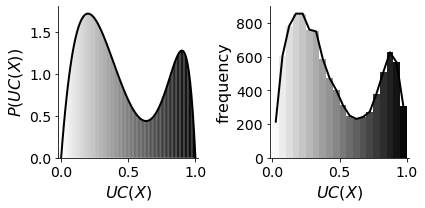

In [5]:
mixture_model_rv.plot_pdf_and_hist(size=10000)

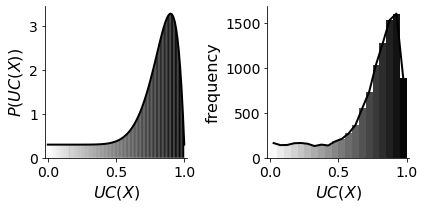

In [8]:
mixture_model_rv = MixtureModel([stats.beta(10, 2), stats.uniform(0, 1)], weights=[0.7, 0.3])
mixture_model_rv.plot_pdf_and_hist(size=10000)

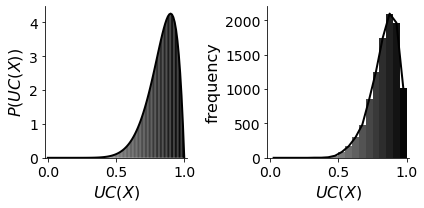

In [7]:
mixture_model_rv = MixtureModel([stats.beta(10, 2)], weights=[1])
mixture_model_rv.plot_pdf_and_hist(size=10000)

In [13]:
def intrinsic_label_data_generator(pos_density_rvs, neg_density_rvs, 
                                   p_p_list=[0.2, 0.7], 
                                   size_list=[100000, 100000], 
                                   period_list=['base', 'target']):
    """
    This is a funcation that...
      
    Attributes:
        a_pos: alpha value of the Beta distribution for the GT positive items
        b_pos: beta value of the Beta distribution for the GT positive items
    """
    
    # configurations
    num_period = len(p_p_list)
    fig, axes = plt.subplots(1 + num_period, 4, figsize=(14, 3 + 3 * num_period))

    # positive density function
    pos_density_pdf = pos_density_rvs.pdf(theor_cx_axis)

    # negative density function
    neg_density_pdf = neg_density_rvs.pdf(theor_cx_axis)

    # first row: plot the conditional density function
    for slice_idx in range(num_theor_slice):
        transpancy = (theor_cx_axis[slice_idx] + theor_cx_axis[slice_idx+1]) / 2
        axes[0, 0].fill_between([theor_cx_axis[slice_idx], theor_cx_axis[slice_idx+1]], 
                                [0, 0], 
                                [pos_density_pdf[slice_idx], pos_density_pdf[slice_idx+1]], 
                                facecolor=positive_color, alpha=transpancy, lw=0, zorder=40)

        axes[0, 0].fill_between([theor_cx_axis[slice_idx], theor_cx_axis[slice_idx+1]], 
                                [0, 0], 
                                [neg_density_pdf[slice_idx], neg_density_pdf[slice_idx+1]], 
                                facecolor=negative_color, alpha=transpancy, lw=0)

    axes[0, 0].plot(theor_cx_axis, pos_density_pdf, c=positive_color, lw=2, zorder=40,
            label=f'$P(UC(X)|GT=1)$')
    axes[0, 0].plot(theor_cx_axis, neg_density_pdf, c=negative_color, lw=2, zorder=40,
            label=f'$P(UC(X)|GT=0)$')

    axes[0, 0].set_xlabel('$UC(X)$', fontsize=16)
    axes[0, 0].set_ylabel('$P(UC(X)|GT)$', fontsize=16)
    axes[0, 0].set_xlim([0, 1.02])
    axes[0, 0].set_ylim(ymin=0)
    axes[0, 0].set_yticks([])
    axes[0, 0].legend(frameon=False)
    
    for row_idx, (p_p, size, period) in enumerate(zip(p_p_list, size_list, period_list)):
        row_idx += 1

        p_n = 1 - p_p
        num_pos = int(size * p_p)
        num_neg = size - num_pos
        
        pos_draws = pos_density_rvs.rvs(num_pos)
        neg_draws = neg_density_rvs.rvs(num_neg)
        
        pos_hist, _ = np.histogram(pos_draws, bins=empir_cx_axis)
        neg_hist, _ = np.histogram(neg_draws, bins=empir_cx_axis)
        all_hist = pos_hist + neg_hist
        
        # data output module
        uc_x_array = np.concatenate((pos_draws, neg_draws))
        gt_list = [True] * num_pos + [False] * num_neg

        url_array = np.random.choice(['yes', 'no'], size)
        lang_array = np.random.choice(['en', 'es'], size)

        output_df = pd.DataFrame(data={'has_url': url_array,
                                       'lang': lang_array,
                                       'UC(X)': uc_x_array, 
                                       'GT': gt_list})
        output_df = output_df.sample(frac=1).reset_index(drop=True)
        output_df.to_csv(f'data/dataset1_{period}.csv', sep=',', index=False)
        
        # plot
        axes[row_idx, 0].bar([0, 1], [p_n, p_p], width=0.7,
                             color=[negative_color, positive_color], lw=2, edgecolor='k')
        axes[row_idx, 0].set_xticks([0, 1])
        axes[row_idx, 0].set_xticklabels(['$P(GT=0)$', '$P(GT=1)$'], fontsize=16)
        axes[row_idx, 0].set_xlabel(period, fontsize=16)
        axes[row_idx, 0].set_ylabel('$P(GT)$', fontsize=16)
        axes[row_idx, 0].set_ylim([0, 1])
        
        axes[row_idx, 0].text(0, p_n, f'{p_n:.2f}', color='k', ha='center', va='bottom', fontsize=16)
        axes[row_idx, 0].text(1, p_p, f'{p_p:.2f}', color='k', ha='center', va='bottom', fontsize=16)

        for bin_idx in range(num_empir_bin):            
            transpancy = (empir_cx_axis[bin_idx] + empir_cx_axis[bin_idx+1]) / 2
            axes[row_idx, 1].fill_between([empir_cx_axis[bin_idx], empir_cx_axis[bin_idx+1]], 
                                          [0, 0], 
                                          [neg_hist[bin_idx], neg_hist[bin_idx]], 
                                          facecolor=negative_color, alpha=transpancy, lw=0)

            axes[row_idx, 1].fill_between([empir_cx_axis[bin_idx], empir_cx_axis[bin_idx+1]], 
                                          [neg_hist[bin_idx], neg_hist[bin_idx]], 
                                          [all_hist[bin_idx], all_hist[bin_idx]], 
                                          facecolor=positive_color, alpha=transpancy, lw=0, zorder=40)

            axes[row_idx, 2].fill_between([empir_cx_axis[bin_idx], empir_cx_axis[bin_idx+1]], 
                                          [0, 0], 
                                          [all_hist[bin_idx], all_hist[bin_idx]], 
                                          facecolor=unknown_color, alpha=transpancy, lw=0, zorder=40)

        axes[row_idx, 1].plot((empir_cx_axis[1:] + empir_cx_axis[:-1]) / 2, 
                              all_hist, c=unknown_color, lw=2, zorder=50)
        axes[row_idx, 2].plot((empir_cx_axis[1:] + empir_cx_axis[:-1]) / 2, 
                              all_hist, c=unknown_color, lw=2, zorder=50)
        
        train_UCX = np.concatenate((pos_draws, neg_draws)).reshape(-1, 1)
        train_GT = np.concatenate((np.ones(num_pos), np.zeros(num_neg))).ravel()
        prob_cali_func = LogisticRegression(fit_intercept=True).fit(train_UCX, train_GT)
        prob_cali_curve = prob_cali_func.predict_proba(empir_cx_axis.reshape(-1, 1))[:, -1]
        prob_cali_curve_w = prob_cali_func.coef_[0][0]
        prob_cali_curve_b = prob_cali_func.intercept_[0]
        
        axes[row_idx, 3].plot(empir_cx_axis, prob_cali_curve, 'k--', lw=2, 
                              label=f'Platt scaling \n w={prob_cali_curve_w:.2f} \n b={prob_cali_curve_b:.2f}')

        axes[row_idx, 3].set_ylabel('$CC(X)$', fontsize=16)
        axes[row_idx, 3].set_ylim([-0.02, 1.02])
        axes[row_idx, 3].legend(frameon=False)

        for col_idx in [1, 2, 3]:
            axes[row_idx, col_idx].set_xlabel('$UC(X)$', fontsize=16)
            axes[row_idx, col_idx].set_xlim([0, 1.02])
            axes[row_idx, col_idx].set_xticks([0, 0.5, 1])
            axes[row_idx, col_idx].set_ylim(ymin=0)

        for col_idx in [1, 2]:
            axes[row_idx, col_idx].set_ylabel('frequency', fontsize=16)
#             axes[row_idx, col_idx].yaxis.set_major_formatter(FuncFormatter(concise_fmt))

    for col_idx in [1, 2, 3]:
        axes[0, col_idx].set_axis_off()

    for ax in axes.ravel():
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.tick_params(axis='both', which='major', labelsize=14)

    plt.tight_layout()

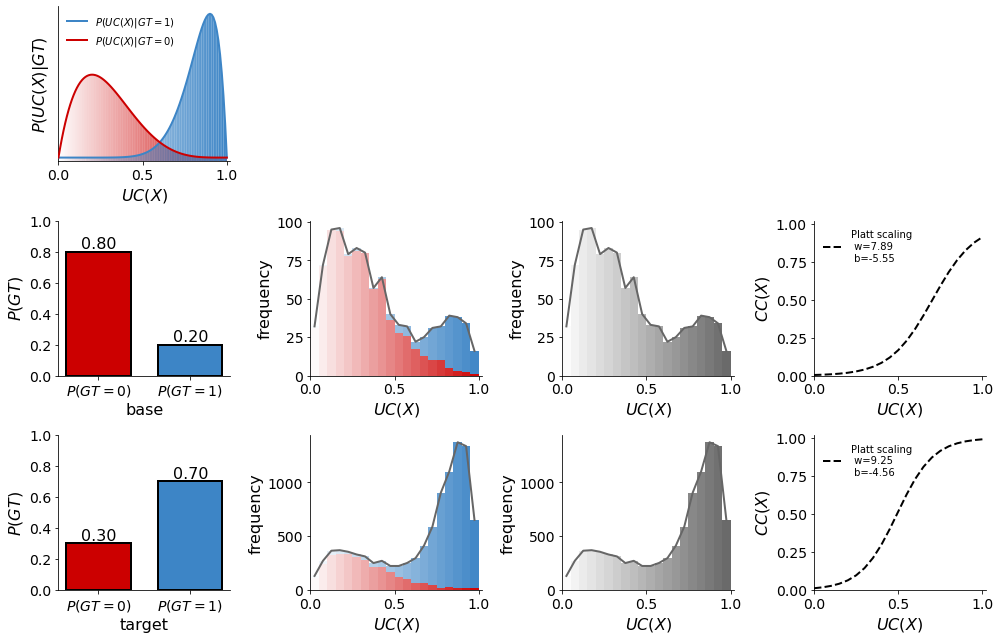

In [14]:
# y -> x data simulation configuration
good_pos_density_rvs = MixtureModel([stats.beta(10, 2), stats.uniform(0, 1)], weights=[0.9, 0.1])
good_neg_density_rvs = MixtureModel([stats.beta(2, 5), stats.uniform(0, 1)], weights=[0.9, 0.1])

intrinsic_label_data_generator(good_pos_density_rvs, good_neg_density_rvs,
                               p_p_list=[0.2, 0.7], size_list=[1000, 10000], 
                               period_list=['base', 'target'])

## Extrinsic Labels $\mathcal{X} \rightarrow GT$

In [30]:
# this plot is generated by simulation parameters: pos_gt_density and neg_gt_density
# positive and negative density function
def extrinsic_label_data_generator(prob_cali_func, 
                                   uc_freq_list, period_list=['base', 'target']):
    """
    This is a funcation that...
      
    Attributes:
        a_pos: alpha value of the Beta distribution for the GT positive items
        b_pos: beta value of the Beta distribution for the GT positive items
    """
    
    # configurations
    num_period = len(period_list)
    fig, axes = plt.subplots(1 + num_period, 4, figsize=(14, 3 + 3 * num_period))
    
    # first row: plot the conditional density function
    prob_cali_curve = prob_cali_func.predict_proba(theor_cx_axis.reshape(-1, 1))[:, -1]
    prob_cali_curve_w = prob_cali_func.coef_[0][0]
    prob_cali_curve_b = prob_cali_func.intercept_[0]

    axes[0, 0].plot(theor_cx_axis, prob_cali_curve, 'k--', lw=2, 
                    label=f'Platt scaling \n w={prob_cali_curve_w:.2f} \n b={prob_cali_curve_b:.2f}')

    axes[0, 0].set_xlabel('$UC(X)$', fontsize=16)
    axes[0, 0].set_ylabel('$CC(X)$', fontsize=16)
    axes[0, 0].set_ylim([-0.02, 1.02])
    axes[0, 0].legend(frameon=False)
    
    for row_idx, (uc_freq, period) in enumerate(zip(uc_freq_list, period_list)):        
        row_idx += 1
        
        cc_freq = prob_cali_func.predict_proba(uc_freq.reshape(-1, 1))[:, -1]
        
        pos_draws = []
        neg_draws = []

        for uc, cc in zip(uc_freq, cc_freq):
            gt = random.choices([0, 1], [1-cc, cc])[0]
            if gt:
                pos_draws.append(uc)
            else:
                neg_draws.append(uc)
        
        print(len(pos_draws) / len(uc_freq))
        pos_hist, _ = np.histogram(pos_draws, bins=empir_cx_axis)
        neg_hist, _ = np.histogram(neg_draws, bins=empir_cx_axis)
        all_hist = pos_hist + neg_hist
        
        # data output module
        gt_list = [True] * len(pos_draws) + [False] * len(neg_draws)
        size = len(uc_freq)

        url_array = np.random.choice(['yes', 'no'], size)
        lang_array = np.random.choice(['en', 'es'], size)

        output_df = pd.DataFrame(data={'has_url': url_array,
                                       'lang': lang_array,
                                       'UC(X)': uc_freq, 
                                       'GT': gt_list})
        output_df = output_df.sample(frac=1).reset_index(drop=True)
        output_df.to_csv(f'data/dataset1_{period}.csv', sep=',', index=False)
        
        # plot
        for bin_idx in range(num_empir_bin):            
            transpancy = (empir_cx_axis[bin_idx] + empir_cx_axis[bin_idx+1]) / 2
            axes[row_idx, 0].fill_between([empir_cx_axis[bin_idx], empir_cx_axis[bin_idx+1]], 
                                          [0, 0], 
                                          [all_hist[bin_idx], all_hist[bin_idx]], 
                                          facecolor=unknown_color, alpha=transpancy, lw=0, zorder=40)
            
            axes[row_idx, 1].fill_between([empir_cx_axis[bin_idx], empir_cx_axis[bin_idx+1]], 
                                          [0, 0], 
                                          [neg_hist[bin_idx], neg_hist[bin_idx]], 
                                          facecolor=negative_color, alpha=transpancy, lw=0)

            axes[row_idx, 1].fill_between([empir_cx_axis[bin_idx], empir_cx_axis[bin_idx+1]], 
                                          [neg_hist[bin_idx], neg_hist[bin_idx]], 
                                          [all_hist[bin_idx], all_hist[bin_idx]], 
                                          facecolor=positive_color, alpha=transpancy, lw=0, zorder=40)
            
            axes[row_idx, 2].fill_between([empir_cx_axis[bin_idx], empir_cx_axis[bin_idx+1]], 
                                          [0, 0], 
                                          [neg_hist[bin_idx], neg_hist[bin_idx]], 
                                          facecolor=negative_color, alpha=transpancy, lw=0)

            axes[row_idx, 2].fill_between([empir_cx_axis[bin_idx], empir_cx_axis[bin_idx+1]], 
                                          [0, 0], 
                                          [pos_hist[bin_idx], pos_hist[bin_idx]], 
                                          facecolor=positive_color, alpha=transpancy, lw=0, zorder=40)

        axes[row_idx, 0].plot((empir_cx_axis[1:] + empir_cx_axis[:-1]) / 2, 
                              all_hist, c=unknown_color, lw=2, zorder=50)
        axes[row_idx, 1].plot((empir_cx_axis[1:] + empir_cx_axis[:-1]) / 2, 
                              all_hist, c=unknown_color, lw=2, zorder=50)
        axes[row_idx, 2].plot((empir_cx_axis[1:] + empir_cx_axis[:-1]) / 2, 
                              pos_hist, c=positive_color, lw=2, zorder=50)
        axes[row_idx, 2].plot((empir_cx_axis[1:] + empir_cx_axis[:-1]) / 2, 
                              neg_hist, c=negative_color, lw=2, zorder=50)

        p_n = len(neg_draws) / len(uc_freq)
        p_p = 1 - p_n

        axes[row_idx, 3].bar([0, 1], [p_n, p_p], width=0.7, 
                             color=[negative_color, positive_color], lw=2, edgecolor='k')
        axes[row_idx, 3].set_xticks([0, 1])
        axes[row_idx, 3].set_xticklabels(['$P(GT=0)$', '$P(GT=1)$'], fontsize=16)
        axes[row_idx, 3].set_xlabel(period, fontsize=16)
        axes[row_idx, 3].set_ylabel('$P(GT)$', fontsize=16)
        axes[row_idx, 3].set_ylim([0, 1])
        axes[row_idx, 3].text(0, p_n, f'{p_n:.2f}', color='k', ha='center', va='bottom', fontsize=16)
        axes[row_idx, 3].text(1, p_p, f'{p_p:.2f}', color='k', ha='center', va='bottom', fontsize=16)

    for row_idx in [1, 2]:
        for col_idx in [0, 1, 2]:
            axes[row_idx, col_idx].set_xlabel('$UC(X)$', fontsize=16)
            axes[row_idx, col_idx].set_xlim([0, 1.02])
            axes[row_idx, col_idx].set_xticks([0, 0.5, 1])
            axes[row_idx, col_idx].set_ylim(ymin=0)

        for col_idx in [0, 1, 2]:
            axes[row_idx, col_idx].set_ylabel('frequency', fontsize=16)
#             axes[row_idx, col_idx].yaxis.set_major_formatter(FuncFormatter(concise_fmt))


    for col_idx in [1, 2, 3]:
        axes[0, col_idx].set_axis_off()

    for ax in axes.ravel():
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.tick_params(axis='both', which='major', labelsize=14)

    plt.tight_layout()

0.2209
0.4542


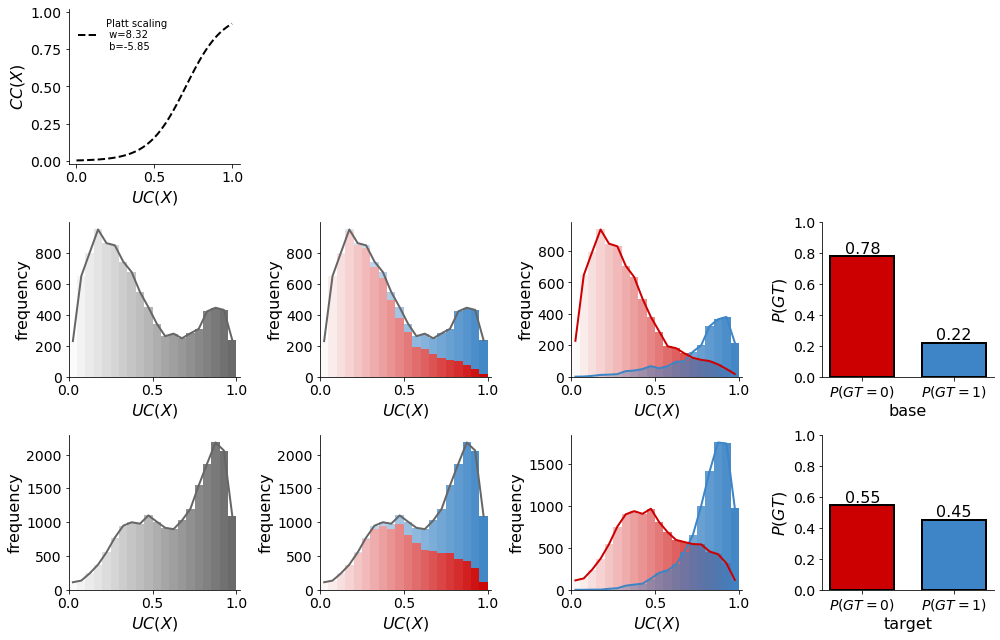

In [31]:
# y -> x data simulation configuration
w = 8.32
b = -5.85

good_lr_regressor = LogisticRegression()
good_lr_regressor.coef_ = np.array([[w]])
good_lr_regressor.intercept_ = np.array([b])
good_lr_regressor.classes_=np.array([0, 1])

any_density_rvs1 = MixtureModel([stats.beta(10, 2), stats.beta(2, 5), stats.uniform(0, 1)], 
                                weights=[0.2, 0.7, 0.1])

any_density_rvs2 = MixtureModel([stats.beta(10, 2), stats.beta(4, 5), stats.uniform(0, 1)], 
                                weights=[0.5, 0.4, 0.1])

extrinsic_label_data_generator(good_lr_regressor, 
                               [any_density_rvs1.rvs(10000), any_density_rvs2.rvs(20000)],
                               period_list=['base', 'target'])